# Chap 18 - Ex2: Apply ARIMA for daily_min_temperature.csv data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

In [3]:
min_temp = (
    pd.read_csv('data/daily_min_temperatures.csv')
    .assign(Date=lambda df: pd.to_datetime(df['Date']))
    .set_index('Date')
    .asfreq('D')  # Change 'D' to 'M', 'W', etc. if needed
    .assign(Temp=lambda df: df['Temp'].fillna(df['Temp'].median()))
)

min_temp

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


## <span style  = 'color:yellow'> Check the seasonal feature of the time series data

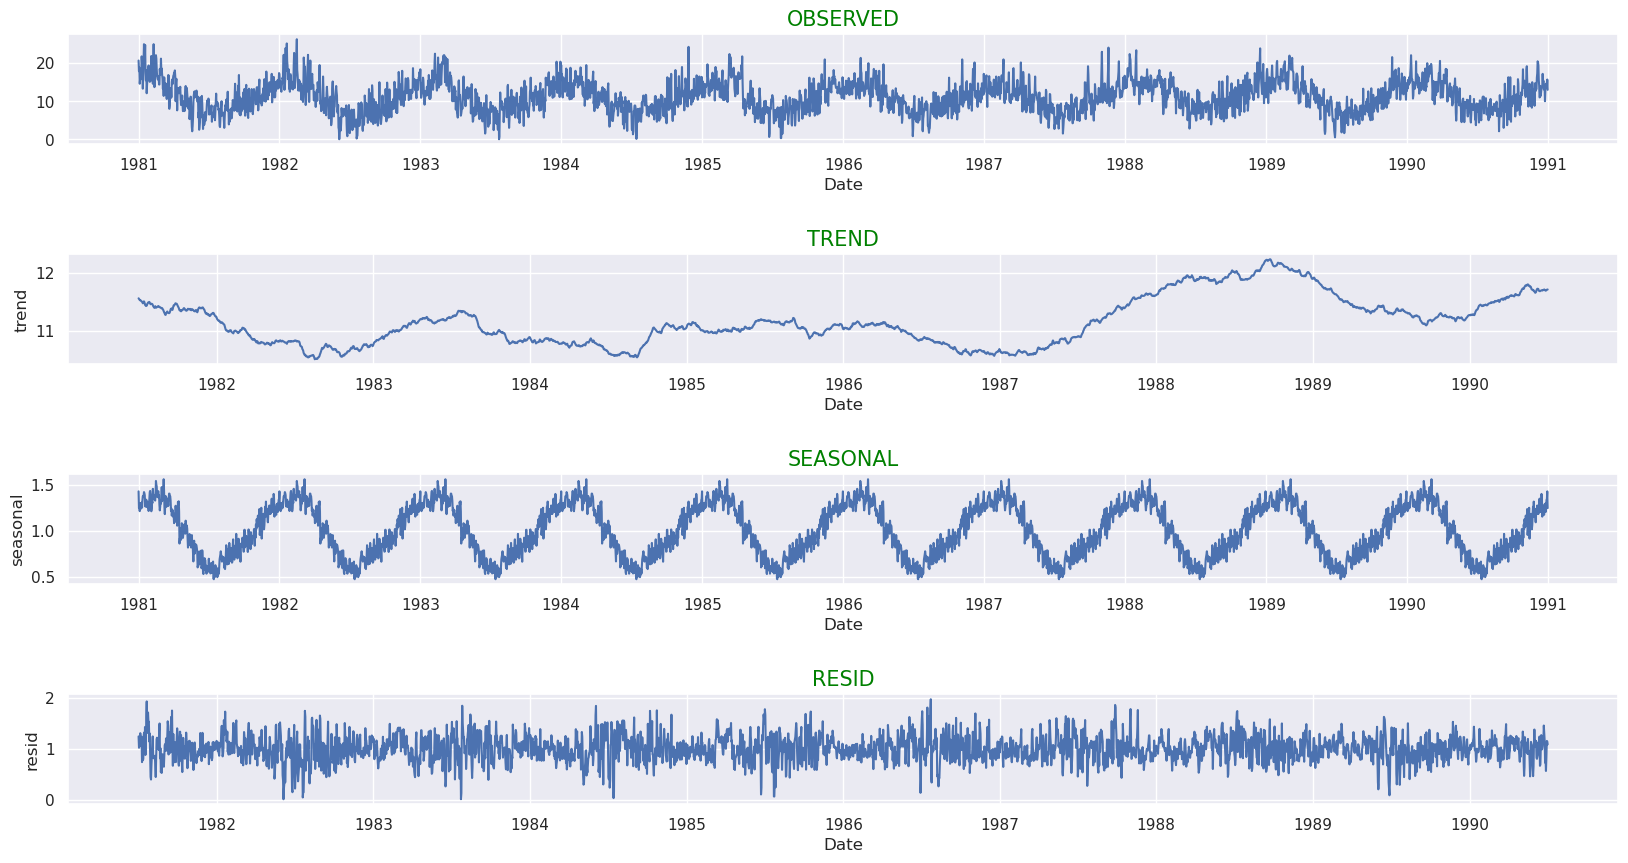

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_check = seasonal_decompose(
    min_temp+0.05, 
    model='multiplicative',
    period=365
)

attr = ['observed', 'trend', 'seasonal', 'resid']

sbn.set_theme(style='darkgrid')
plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace=1)
for i in range(len(attr)):
    plt.subplot(4,1,i+1)
    sbn.lineplot(data=getattr(seasonal_check, attr[i]))
    plt.title(attr[i].upper(), size = 15, color = 'green')
plt.show()

## <span style  = 'color:yellow'> Build SARIMA model (because the data has seasonality)

In [8]:
import pmdarima as pm

train_set, test_set = pm.model_selection.train_test_split(min_temp, train_size=int(0.8*min_temp.shape[0]))

arima_model = pm.auto_arima(train_set,                 
                start_p = 2, max_p = 5,
                start_q = 2, max_q = 5,
                m=7, seasonal = True,
                suppress_warnings=True, 
                stepwise=True, trace = True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16478.032, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=13905.480, Time=0.79 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14592.252, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=22722.098, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=13927.535, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=13886.993, Time=2.31 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=13810.630, Time=4.63 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=13811.914, Time=2.05 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=6.46 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=13810.096, Time=4.83 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=13897.869, Time=1.42 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=13909.068, Time=0.44 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=14915.952, Time=3.78 sec
 ARIMA(2,0,0)(1,0,2)[7] interce

## <span style  = 'color:yellow'> Forecast

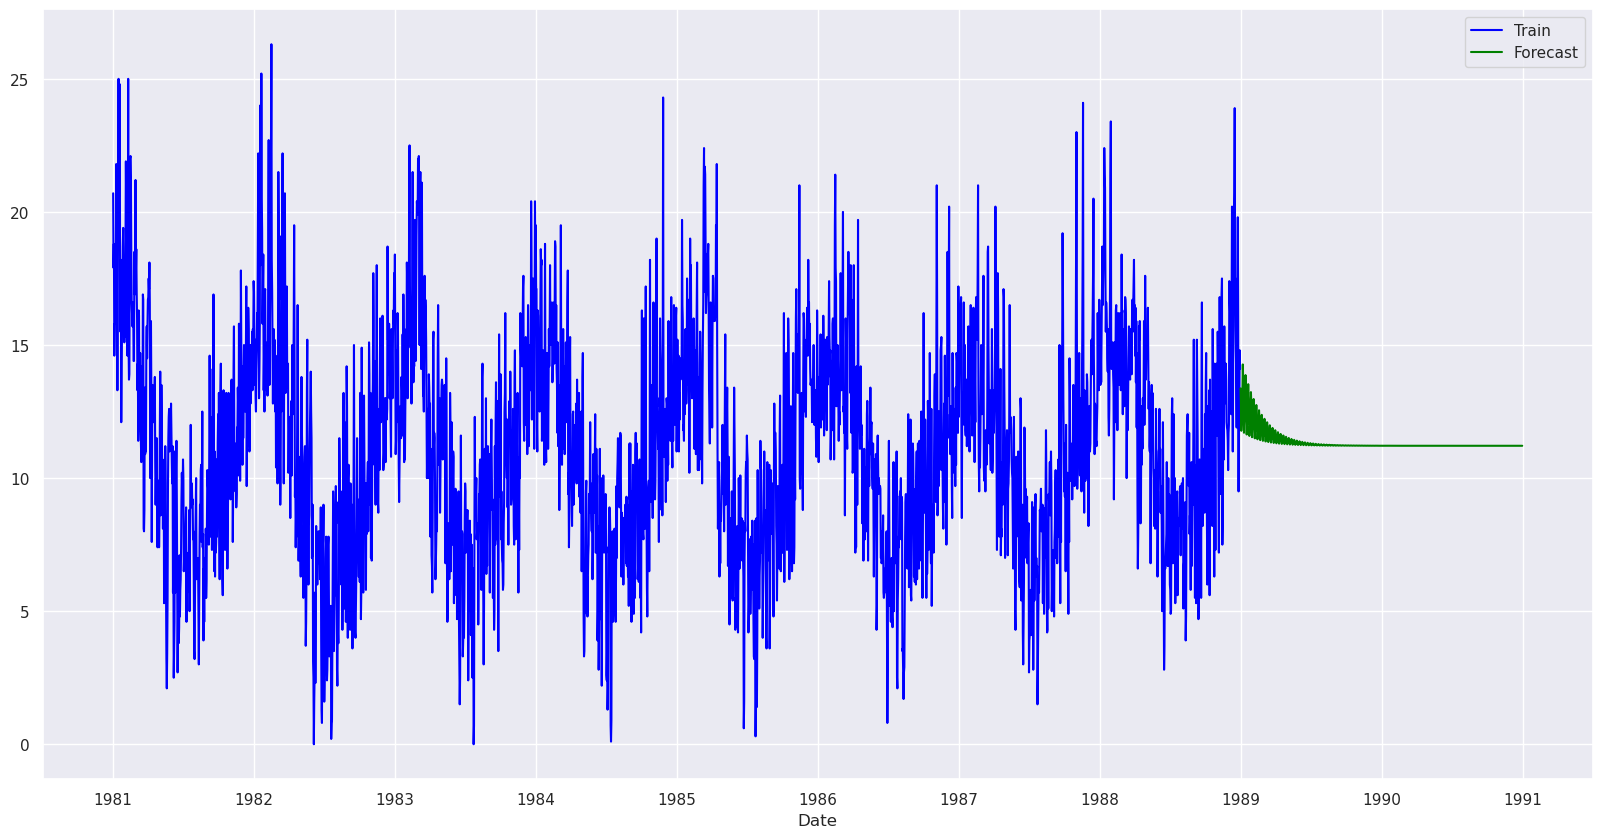

In [9]:
forecasts_test = arima_model.predict(test_set.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(20, 10))
sbn.lineplot(x=train_set.index, y=train_set.values.ravel(), color='blue', label='Train')
sbn.lineplot(x=forecasts_test.index, y=forecasts_test.values.ravel(), color='green', label='Forecast')
plt.legend()
plt.show()

## <span style  = 'color:yellow'> Evaluation

Accuracy on train set: 0.01590808722061432
Accuracy on test set: 0.03947220285570374

Mean squared error test set: 16.154553928969015
Mean absolute error test set: 3.3139884695753965



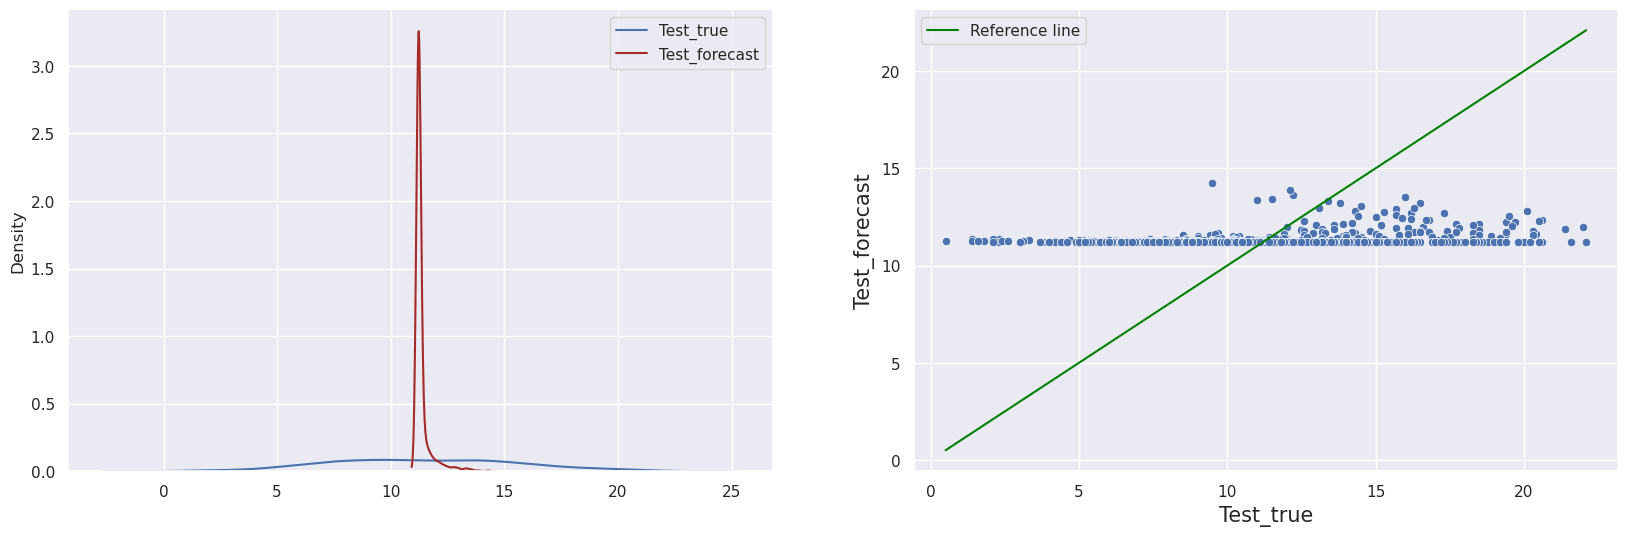

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecasts_train = arima_model.predict(train_set.shape[0])

print(f'Accuracy on train set: {r2_score(train_set.values, forecasts_train.values)}')
print(f'Accuracy on test set: {r2_score(test_set.values, forecasts_test.values)}')
print()

print(f'Mean squared error test set: {mean_squared_error(test_set.values, forecasts_test.values)}')
print(f'Mean absolute error test set: {mean_absolute_error(test_set.values, forecasts_test.values)}')
print()

sbn.set_theme(style='darkgrid')
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sbn.kdeplot(test_set.values,  label = "Test_true", color = 'green')
sbn.kdeplot(forecasts_test.values, label = "Test_forecast", color = 'brown')
plt.legend()

plt.subplot(1,2,2)
sbn.lineplot(x = [test_set.values.min(), test_set.values.max()], 
             y = [test_set.values.min(), test_set.values.max()], 
             label = 'Reference line', color = 'green')
sbn.scatterplot(x = test_set.values.ravel(), y = forecasts_test.values.ravel())
plt.xlabel("Test_true", size=15)
plt.ylabel("Test_forecast", size=15)
plt.show()